# 평가 조건
1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
    - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
    - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
    - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

# 모듈 임포트

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 데이터 로드 함수
- 실험에 사용할 로이터 뉴스 데이터를 불러오는 함수를 구현합니다.
- 필요에 따라 단어수를 조정할 수 있도록 구현하였습니다.

In [23]:
def data_load(num_words=None):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    
    print('Train data 샘플의 수: {}'.format(len(x_train)))
    print('Test data 샘플의 수: {}'.format(len(x_test)))
    print('\n')
    num_classes = max(y_train) + 1
    print('클래스의 수 : {}'.format(num_classes))
    print('\n')   
    print('Train 데이터의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('Train 데이터의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    return x_train, y_train, x_test, y_test

2121728/2110848 [==============================] - 0s 0us/step
Train data 샘플의 수: 8982
Test data 샘플의 수: 2246


클래스의 수 : 46


Train 데이터의 최대 길이 :2376
Train 데이터의 평균 길이 :145.5398574927633


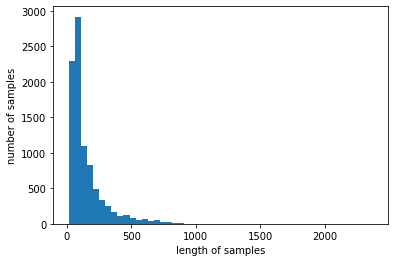

In [3]:
x_train, y_train, x_test, y_test = data_load(num_words=5000)

- Train data는 9000여개, Test data는 약 2200여개 입니다. 또한 정답의 클래스 수는 46개 입니다.
- 길이가 가장 긴 뉴스의 길이는 2,376입니다. 평균 뉴스의 길이는 145 입니다.
- 시각화된 그래프의 분포로 봤을 때 대부분의 뉴스가 500자 이하의 길이에 분포하지만 500~1,000 사이의 길이를 가지는 뉴스도 일부 존재합니다.

## 클래스 분포 측정 함수

In [4]:
def class_check(y_train):
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y_train)
    plt.show()

    unique_elements, counts_elements = np.unique(y_train, return_counts=True)
    print("각 클래스 빈도수")
    for i in range(len(unique_elements)):
        print('{}번 클래스 : {}개'.format(unique_elements[i],counts_elements[i]))

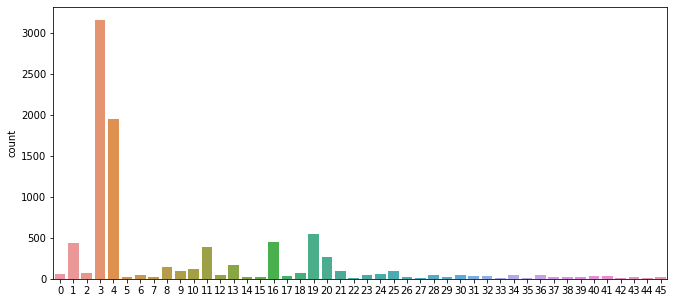

각 클래스 빈도수
0번 클래스 : 55개
1번 클래스 : 432개
2번 클래스 : 74개
3번 클래스 : 3159개
4번 클래스 : 1949개
5번 클래스 : 17개
6번 클래스 : 48개
7번 클래스 : 16개
8번 클래스 : 139개
9번 클래스 : 101개
10번 클래스 : 124개
11번 클래스 : 390개
12번 클래스 : 49개
13번 클래스 : 172개
14번 클래스 : 26개
15번 클래스 : 20개
16번 클래스 : 444개
17번 클래스 : 39개
18번 클래스 : 66개
19번 클래스 : 549개
20번 클래스 : 269개
21번 클래스 : 100개
22번 클래스 : 15개
23번 클래스 : 41개
24번 클래스 : 62개
25번 클래스 : 92개
26번 클래스 : 24개
27번 클래스 : 15개
28번 클래스 : 48개
29번 클래스 : 19개
30번 클래스 : 45개
31번 클래스 : 39개
32번 클래스 : 32개
33번 클래스 : 11개
34번 클래스 : 50개
35번 클래스 : 10개
36번 클래스 : 49개
37번 클래스 : 19개
38번 클래스 : 19개
39번 클래스 : 24개
40번 클래스 : 36개
41번 클래스 : 30개
42번 클래스 : 13개
43번 클래스 : 21개
44번 클래스 : 12개
45번 클래스 : 18개


In [5]:
class_check(y_train)

- 해당 데이터는 전형적인 불균형 데이터입니다.
- 3번과 4번 클래스에 절반 이상의 데이터가 존재함을 알 수 있습니다.

## 데이터 복원 함수
- 현재 데이터는 이미 단어가 정수형으로 바뀐 형태로 맵핑되어 있습니다.
- 해당 데이터를 다시 문자로 돌려주는 디코딩 함수를 구현하였습니다.

In [24]:
def data_decoding(x_train, x_test):
    
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = {index+3 : word for word, index in word_index.items()}
    word_to_index = {word:index for index, word in index_to_word.items()}
    for index, token in enumerate(("<pad>", "<sos>", "<unk>", "<eos>")):
        index_to_word[index]=token
        
    train_decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        train_decoded.append(t)
    x_train_ = train_decoded
    
    test_decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        test_decoded.append(t)
    x_test_ = test_decoded
    
    return x_train_, x_test_, index_to_word, word_to_index

In [7]:
decoding_x_train, decoding_x_test, index_to_word, word_to_index = data_decoding(x_train, x_test)

565248/550378 [==============================] - 0s 0us/step


In [8]:
print(decoding_x_train[0])
print('train 데이터 수:',len(decoding_x_train))
print('\n')
print(decoding_x_test[0])
print('test 데이터 수:',len(decoding_x_test))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
train 데이터 수: 8982


<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expand

- 데이터가 잘 복원된것을 확인할 수 있습니다.

# 벡터화 함수

In [25]:
def tfidf_transformer(x_train, x_test):
    countvector = CountVectorizer()
    x_train_countvector = countvector.fit_transform(x_train)
    
    tfidf_transformer = TfidfTransformer()
    train_tfidfv = tfidf_transformer.fit_transform(x_train_countvector)
    
    x_test_countvector = countvector.transform(x_test) 
    test_tfidfv = tfidf_transformer.transform(x_test_countvector)
    
    print(train_tfidfv.shape)
    print(test_tfidfv.shape)
    
    return  train_tfidfv, test_tfidfv

In [10]:
train_tfidfv, test_tfidfv = tfidf_transformer(decoding_x_train, decoding_x_test)

(8982, 4867)
(2246, 4867)


# 머신러닝 모델 실행 함수

In [64]:
def run_multiple_models(models, X_train, y_train, X_test, y_test):
    model_reports = []
    for model_name, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        we_precision = precision_score(y_test, y_pred, average='weighted')
        we_recall = recall_score(y_test, y_pred, average='weighted')
        we_f1 = f1_score(y_test, y_pred, average='weighted')
        model_report = {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision': we_precision,
            'recall': we_recall,
            'f1-score': we_f1,
        }
        model_reports.append(model_report)

    df_reports = pd.DataFrame.from_records(model_reports, columns=['model_name', 'accuracy', 'precision', 'recall', 'f1-score'])
    df_reports.set_index('model_name', inplace=True)

    return df_reports

## 1. 5000개 단어 사전으로 실험

In [65]:
models = {'Naive Bayes': MultinomialNB(),
          'Complement NB': ComplementNB(),
          'Logistic Regression': LogisticRegression(C=10000, penalty='l2', max_iter=3000),
          'SVM': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False), 
          'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
          'RandomForest': RandomForestClassifier(n_estimators=5, random_state=42),
          'GradientBoost': GradientBoostingClassifier(random_state=42)}

reports50 = run_multiple_models(models, train_tfidfv, y_train, test_tfidfv, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 43%|████▎     | 3/7 [08:26<11:15, 168.88s/it]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 57%|█████▋    | 4/7 [10:17<07:30, 150.25s/it]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pre

In [66]:
reports50

,accuracy,precision,recall,f1-score
model_name,,,,
Naive Bayes,0.673197,0.601513,0.673197,0.601250
Complement NB,0.770703,0.756305,0.770703,0.745899
Logistic Regression,0.803651,0.803204,0.803651,0.798560
SVM,0.769813,0.769463,0.769813,0.765838
DecisionTree,0.619768,0.608046,0.619768,0.574507
RandomForest,0.693232,0.673703,0.693232,0.666342
GradientBoost,0.768477,0.773001,0.768477,0.767542


In [89]:
reports50.to_csv('reports_50.csv', index=True)

In [90]:
reports_50 = pd.read_csv('reports_50.csv')


,model_name,accuracy,precision,recall,f1-score
0,Naive Bayes,0.673197,0.601513,0.673197,0.601250
1,Complement NB,0.770703,0.756305,0.770703,0.745899
2,Logistic Regression,0.803651,0.803204,0.803651,0.798560
3,SVM,0.769813,0.769463,0.769813,0.765838
4,DecisionTree,0.619768,0.608046,0.619768,0.574507
5,RandomForest,0.693232,0.673703,0.693232,0.666342
6,GradientBoost,0.768477,0.773001,0.768477,0.767542


In [123]:
def model_accuracy(dataframe):
    # 색상 리스트
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(dataframe.index, dataframe['accuracy'], color=colors[:len(dataframe)])
    plt.xticks(rotation=45)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')

    # 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval,4), ha='center', va='bottom')

    # 범례 추가
    plt.legend(bars, dataframe.index, bbox_to_anchor=(1.3, 1), loc='upper right')

    plt.tight_layout()  # 그래프와 범례가 겹치지 않도록 자동 조정

    plt.show()

In [124]:
def model_recall(dataframe):
    # 색상 리스트
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(dataframe.index, dataframe['recall'], color=colors[:len(dataframe)])
    plt.xticks(rotation=45)
    plt.xlabel('Model')
    plt.ylabel('recall')
    plt.title('recall Comparison')

    # 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval,4), ha='center', va='bottom')

    # 범례 추가
    plt.legend(bars, dataframe.index, bbox_to_anchor=(1.3, 1), loc='upper right')

    plt.tight_layout()  # 그래프와 범례가 겹치지 않도록 자동 조정

    plt.show()

In [125]:
def model_f1score(dataframe):
    # 색상 리스트
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'cyan', 'magenta']

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(dataframe.index, dataframe['f1-score'], color=colors[:len(dataframe)])
    plt.xticks(rotation=45)
    plt.xlabel('Model')
    plt.ylabel('f1-score')
    plt.title('f1-score Comparison')

    # 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval,4), ha='center', va='bottom')

    # 범례 추가
    plt.legend(bars, dataframe.index, bbox_to_anchor=(1.3, 1), loc='upper right')

    plt.tight_layout()  # 그래프와 범례가 겹치지 않도록 자동 조정

    plt.show()

## 1-1. voting
- 개별 모델 당시 recall 값이 가장 높았던 Complement NB, Logistic Regression, SVM 3가지 모델을 이용하여 hard voting 방식을 통한 ensemble 함수를 구현하였습니다.

In [113]:
def model_ensemble(models, X_train, y_train, X_test, y_test):
    voting_clf = VotingClassifier(estimators=models, voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    we_precision = precision_score(y_test, y_pred, average='weighted')
    we_recall = recall_score(y_test, y_pred, average='weighted')
    we_f1 = f1_score(y_test, y_pred, average='weighted')
    
    model_reports = {
        'model_name': ['ensemble'],
        'accuracy': [accuracy],
        'precision': [we_precision],
        'recall': [we_recall],
        'f1-score': [we_f1],
    }

    df_reports = pd.DataFrame(model_reports)
    df_reports.set_index('model_name', inplace=True)

    return df_reports

In [114]:
# 모델 정의
models = [('Complement NB', ComplementNB()),
          ('Logistic Regression', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
          ('SVM', LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False))]

ensemble50 = model_ensemble(models, train_tfidfv, y_train, test_tfidfv, y_test)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [116]:
result50 = pd.concat([reports50, ensemble50])

In [118]:
result50

,accuracy,precision,recall,f1-score
model_name,,,,
Naive Bayes,0.673197,0.601513,0.673197,0.601250
Complement NB,0.770703,0.756305,0.770703,0.745899
Logistic Regression,0.803651,0.803204,0.803651,0.798560
SVM,0.769813,0.769463,0.769813,0.765838
DecisionTree,0.619768,0.608046,0.619768,0.574507
RandomForest,0.693232,0.673703,0.693232,0.666342
GradientBoost,0.768477,0.773001,0.768477,0.767542
ensemble,0.800980,0.801775,0.800980,0.792246


In [166]:
result50.to_csv('result50.csv', index=True)
# reports_50 = pd.read_csv('reports_50.csv')

## 1-2. 시각화

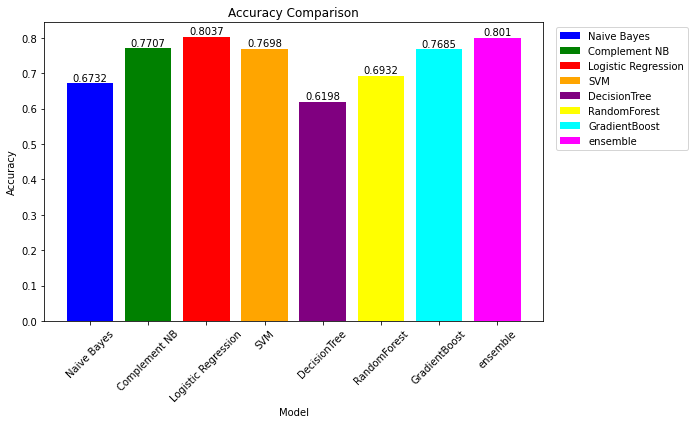

In [126]:
model_accuracy(result50)

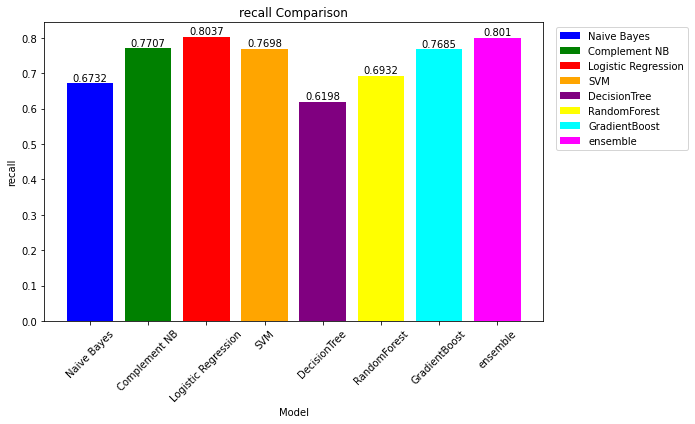

In [128]:
model_recall(result50)

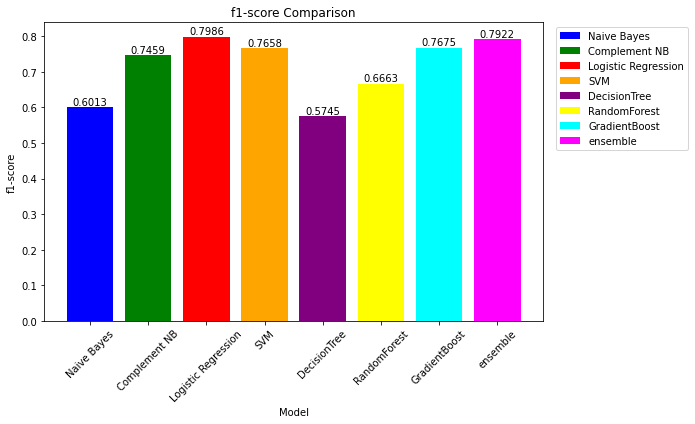

In [127]:
model_f1score(result50)

## 1-3. 평가

- 해당 데이터는 46개의 클래스를 가지고 있으며, 불균형한 데이터입니다.
- 따라서 accuracy로 평가를 하기보다는 F1-score나 Recall 값을 통하여 모델을 평가하는것이 바람직합니다.
- Recall값 기준, Logistic Regression, Ensemble, Complement NB 순으로 높은 성능을 보여주고 있습니다.

## 2. 13000개 단어로 실험

Train data 샘플의 수: 8982
Test data 샘플의 수: 2246


클래스의 수 : 46


Train 데이터의 최대 길이 :2376
Train 데이터의 평균 길이 :145.5398574927633


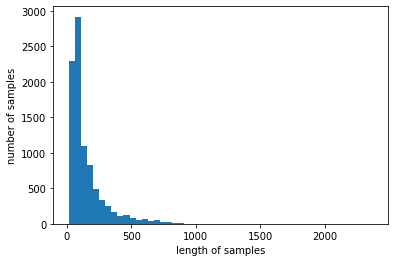

In [129]:
x_train, y_train, x_test, y_test = data_load(num_words=13000)

In [130]:
decoding_x_train, decoding_x_test, index_to_word, word_to_index = data_decoding(x_train, x_test)

In [131]:
train_tfidfv, test_tfidfv = tfidf_transformer(decoding_x_train, decoding_x_test)

(8982, 12451)
(2246, 12451)


In [133]:
models = {'Naive Bayes': MultinomialNB(),
          'Complement NB': ComplementNB(),
          'Logistic Regression': LogisticRegression(C=10000, penalty='l2', max_iter=3000),
          'SVM': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False), 
          'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
          'RandomForest': RandomForestClassifier(n_estimators=5, random_state=42),
          'GradientBoost': GradientBoostingClassifier(random_state=42)}

reports130 = run_multiple_models(models, train_tfidfv, y_train, test_tfidfv, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 43%|████▎     | 3/7 [12:13<20:22, 305.51s/it]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

In [134]:
reports130

,accuracy,precision,recall,f1-score
model_name,,,,
Naive Bayes,0.642921,0.557242,0.642921,0.560410
Complement NB,0.773375,0.755934,0.773375,0.747362
Logistic Regression,0.811220,0.812186,0.811220,0.806120
SVM,0.786732,0.786600,0.786732,0.781764
DecisionTree,0.619323,0.609730,0.619323,0.572697
RandomForest,0.661621,0.638813,0.661621,0.632376
GradientBoost,0.767142,0.769921,0.767142,0.764030


## 2-1. voting

In [135]:
models = [('Complement NB', ComplementNB()),
          ('Logistic Regression', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
          ('SVM', LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False))]

ensemble130 = model_ensemble(models, train_tfidfv, y_train, test_tfidfv, y_test)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
result130 = pd.concat([reports130, ensemble130])

In [167]:
result130.to_csv('result130.csv', index=True)

## 2-2. 시각화

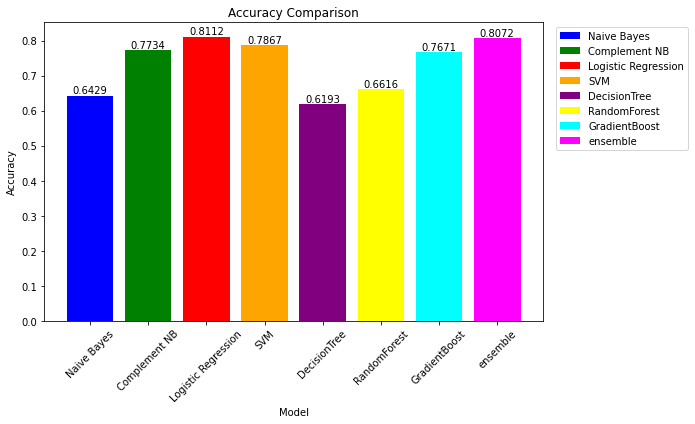

In [140]:
model_accuracy(result130)

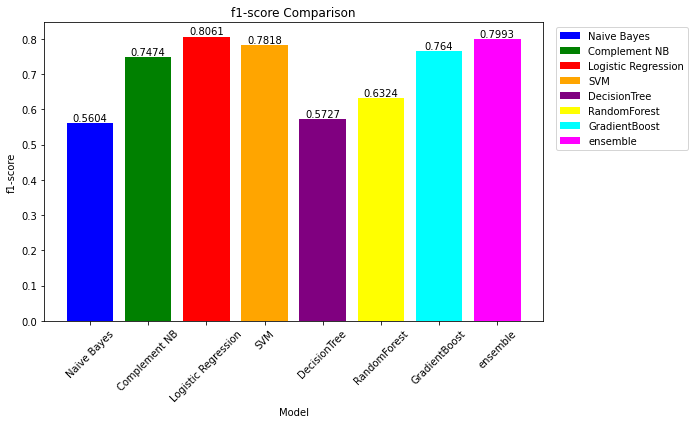

In [141]:
model_f1score(result130)

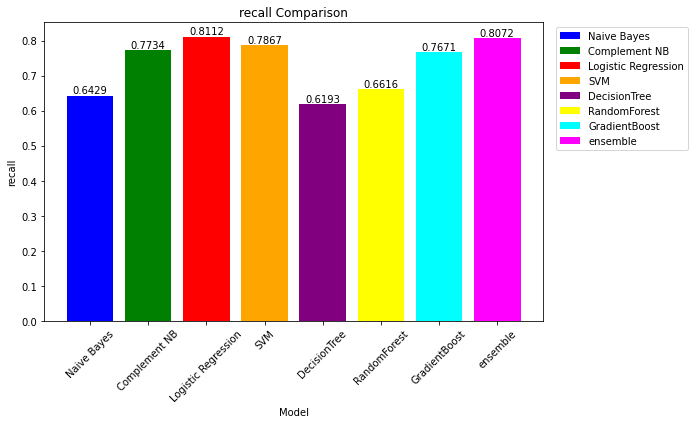

In [142]:
model_recall(result130)

## 2-3. 평가
- 사전이 13000개인 모델에서 Recall 기준으로는 Logistic Regression, Ensemble, SVM 순으로 좋은 성능을 보이고 있습니다.

## 3. 모든 단어로 실험

Train data 샘플의 수: 8982
Test data 샘플의 수: 2246


클래스의 수 : 46


Train 데이터의 최대 길이 :2376
Train 데이터의 평균 길이 :145.5398574927633


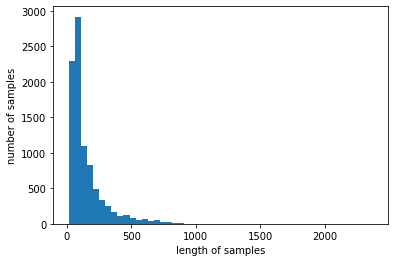

In [143]:
x_train, y_train, x_test, y_test = data_load(num_words=None)

In [144]:
decoding_x_train, decoding_x_test, index_to_word, word_to_index = data_decoding(x_train, x_test)

In [145]:
train_tfidfv, test_tfidfv = tfidf_transformer(decoding_x_train, decoding_x_test)

(8982, 26506)
(2246, 26506)


In [146]:
models = {'Naive Bayes': MultinomialNB(),
          'Complement NB': ComplementNB(),
          'Logistic Regression': LogisticRegression(C=10000, penalty='l2', max_iter=3000),
          'SVM': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False), 
          'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
          'RandomForest': RandomForestClassifier(n_estimators=5, random_state=42),
          'GradientBoost': GradientBoostingClassifier(random_state=42)}

all_reports = run_multiple_models(models, train_tfidfv, y_train, test_tfidfv, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 14%|█▍        | 1/7 [00:00<00:00,  9.68it/s]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 43%|████▎     | 3/7 [14:01<20:45, 311.47s/it]/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 57%|█████▋    | 4/7 [15:35<11:48, 236.22s/it]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classi

In [147]:
all_reports

,accuracy,precision,recall,f1-score
model_name,,,,
Naive Bayes,0.599733,0.498564,0.599733,0.504567
Complement NB,0.764915,0.745940,0.764915,0.734653
Logistic Regression,0.816563,0.818232,0.816563,0.811443
SVM,0.791184,0.794166,0.791184,0.787119
DecisionTree,0.620214,0.618924,0.620214,0.575475
RandomForest,0.652271,0.628474,0.652271,0.621143
GradientBoost,0.769368,0.770238,0.769368,0.765951


## 3-1. voting

In [148]:
models = [('Complement NB', ComplementNB()),
          ('Logistic Regression', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
          ('GradientBoost',GradientBoostingClassifier(random_state=42))]

all_ensemble = model_ensemble(models, train_tfidfv, y_train, test_tfidfv, y_test)

In [149]:
all_result = pd.concat([all_reports, all_ensemble])

In [154]:
all_result

,accuracy,precision,recall,f1-score
model_name,,,,
Naive Bayes,0.599733,0.498564,0.599733,0.504567
Complement NB,0.764915,0.745940,0.764915,0.734653
Logistic Regression,0.816563,0.818232,0.816563,0.811443
SVM,0.791184,0.794166,0.791184,0.787119
DecisionTree,0.620214,0.618924,0.620214,0.575475
RandomForest,0.652271,0.628474,0.652271,0.621143
GradientBoost,0.769368,0.770238,0.769368,0.765951
ensemble,0.810329,0.813163,0.810329,0.799433


In [168]:
all_result.to_csv('all_result.csv', index=True)

## 3-2. 시각화

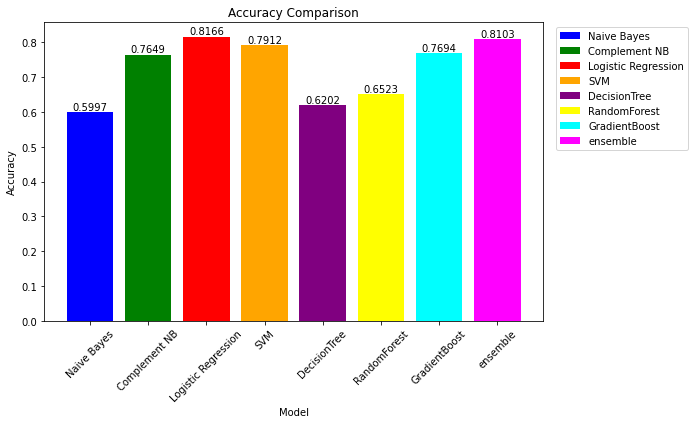

In [150]:
model_accuracy(all_result)

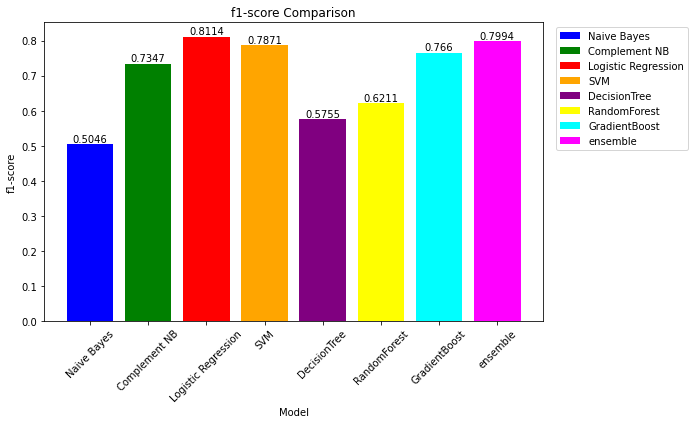

In [151]:
model_f1score(all_result)

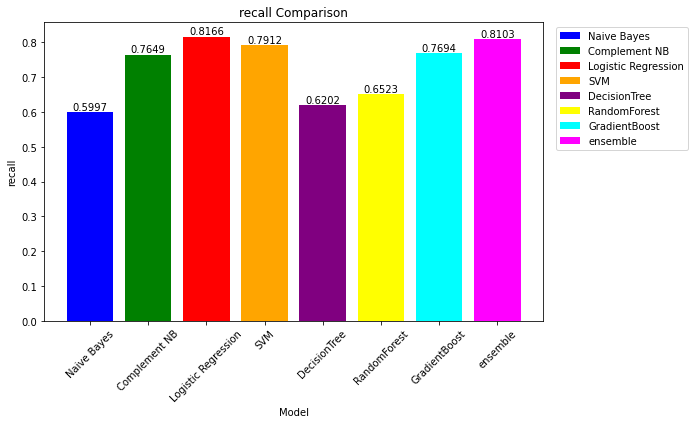

In [152]:
model_recall(all_result)

## 3-3. 평가

- 마지막 모델은 사전의 갯수에 제한을 두지 않고 평가해봤습니다.
- Recall 기준 Logistic Regression, Ensemble, SVM 순으로 좋은 성능을 보이고 있습니다.

# 머신러닝 모델 성능 평가 및 비교

In [5]:
result50_ = pd.read_csv('result50.csv')
result130_ = pd.read_csv('result130.csv')
all_result_ = pd.read_csv('all_result.csv')

In [18]:
def compare_models(df1, df2, df3, metric):

    # 모델명과 accuracy 값을 추출하여 리스트로 저장
    model_names = df1['model_name'].tolist()
    metric1= df1[metric].tolist()
    metric2 = df2[metric].tolist()
    metric3 = df3[metric].tolist()

    # 시각화
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = range(len(model_names))

    plt.bar(index, metric1, width=bar_width, label='5K', alpha=0.7)
    plt.bar([i + bar_width for i in index], metric2, width=bar_width, label='13K', alpha=0.7)
    plt.bar([i + 2*bar_width for i in index], metric3, width=bar_width, label='ALL', alpha=0.7)

    plt.xlabel('Model')
    plt.ylabel('{}'.format(metric))
    plt.title('Comparison of Model {}'.format(metric))
    plt.xticks([i + bar_width for i in index], model_names, rotation=90)
    # 범례 위치 조정
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # 지표 값 추가
    for i, acc in enumerate(metric1):
        plt.text(i, acc, f'{acc:.3f}', ha='center', va='baseline')
    for i, acc in enumerate(metric2):
        plt.text(i + bar_width, acc, f'{acc:.3f}', ha='center', va='top')
    for i, acc in enumerate(metric3):
        plt.text(i + 2*bar_width, acc, f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

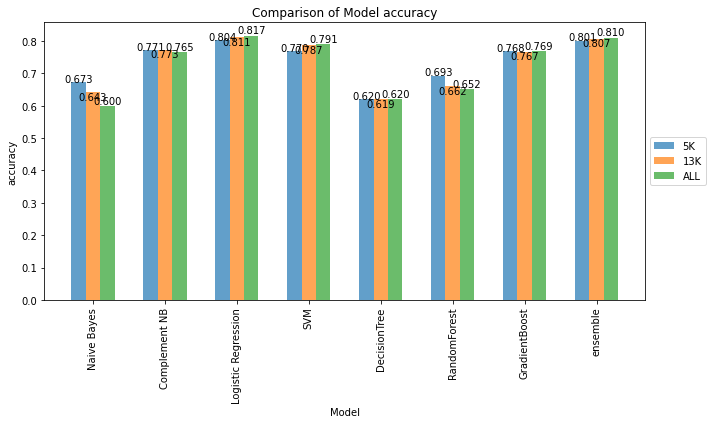

In [19]:
compare_models(result50_,result130_,all_result_,'accuracy')

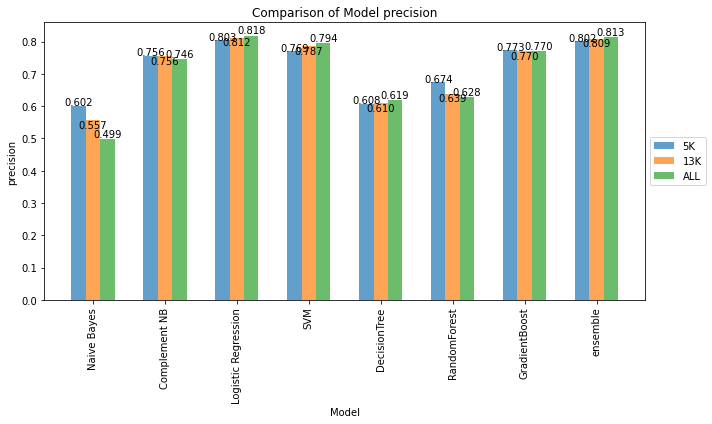

In [20]:
compare_models(result50_,result130_,all_result_,'precision')

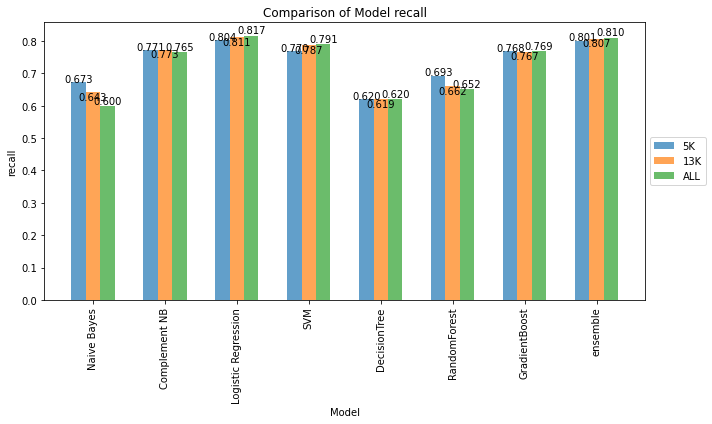

In [21]:
compare_models(result50_,result130_,all_result_,'recall')

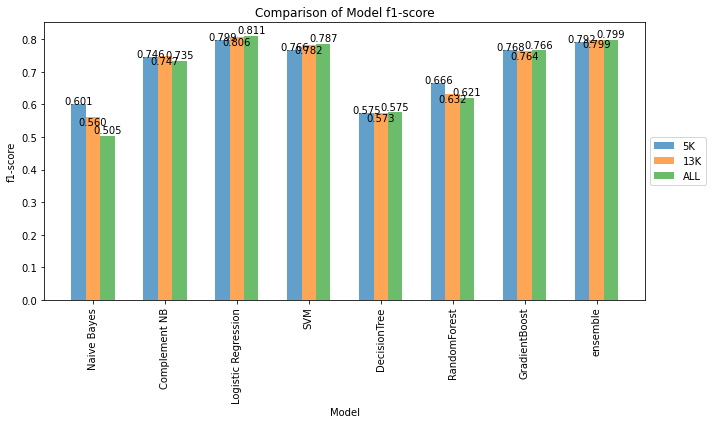

In [22]:
compare_models(result50_,result130_,all_result_,'f1-score')

In [185]:
def compare_vocab(datframe1, datframe2, datframe3, metric):
    # 데이터프레임 병합
    merged_df = pd.concat([datframe1, datframe2, datframe3], keys=['5k', '13k', 'all'])

    # 모델별 그룹화
    grouped_df = merged_df.groupby('model_name')

    # 성능 지표별 비교 시각화
    plt.figure(figsize=(10, 6))
    for model, group in grouped_df:
        plt.plot(group.index.get_level_values(0), group[metric], marker='o', label=model)
        # 지표 값 표시
        for x, y in zip(group.index.get_level_values(0), group[metric]):
            plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

    plt.ylabel('{}'.format(metric))
    plt.title('Model {} Comparison'.format(metric))
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.subplots_adjust(right=0.7)
    plt.tight_layout()
    plt.show()

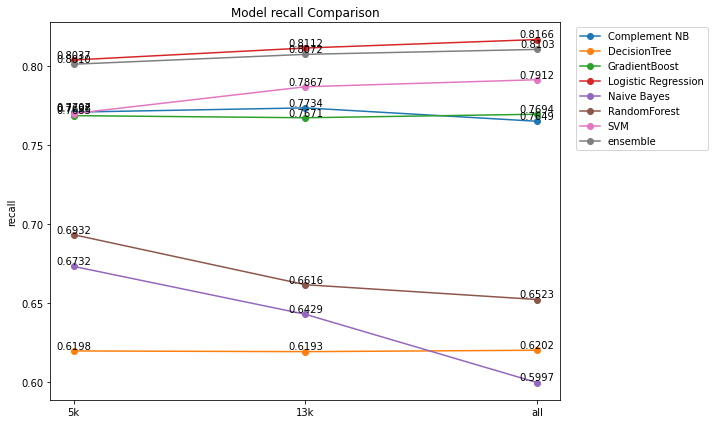

In [187]:
compare_vocab(result50_, result130_, all_result_, 'recall')

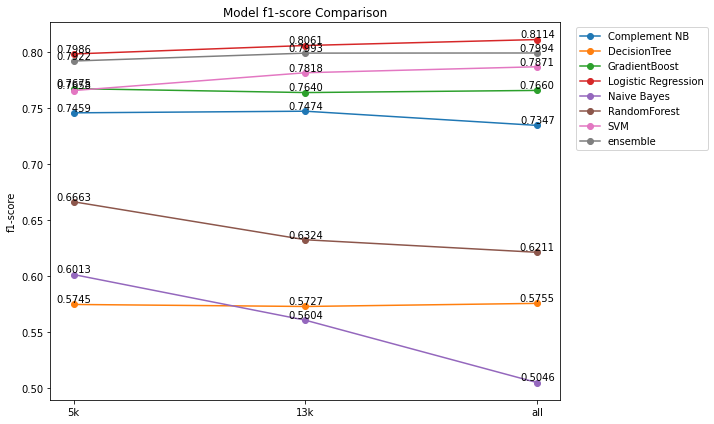

In [188]:
compare_vocab(result50_, result130_, all_result_, 'f1-score')

- 해당 데이터는 46개의 클래스가 존재하는 불균형 클래스입니다.
- 따라서 accuracy로 정확도를 판단하기에는 무리가 있습니다.
- 그래서 저는 recall값과 f1-score를 활용하여 모델을 평가하고자 합니다.
- 총 8개의 모델 중 성능이 가장 좋았던 모델은 모든 사전을 통틀어서 Logistic Regression입니다.
- 시간이 오래걸린다는 단점이 존재하지만, 이진 분류 및 다중 분류에서 모두 좋은 성능을 나타내는 모델입니다.
- f1-score 기준 모든 단어 사전에서 0.8114의 성능을 보였습니다.
- 그 다음으로는 Ensemble, SVM 모델 순으로 좋은 성능을 보였습니다.


- Complement NB는 클래스가 불균형할때 성능을 잘 낸다고 알려져 있지만, 5번째로 높은 성능을 보였습니다.
- Naive Bayes, RandomForest는 오히려 단어장의 크기가 커졌을때 성능이 하락하는 결과를 보였습니다.
- 적은 모델일때 성능이 좋은 Naive Bayes는 오히려 단어장이 커지며 데이터가 늘어난것이 성능 하락의 원인이 아닐까 생각됩니다.


- 모든 모델에 그리드 서치를 하는 코드를 추가한다면 현재의 결과보다는 좋은 성능을 낼 수 있을것으로 생각됩니다.
- 아래의 표는 실험에 사용한 모델들의 특징과 장단점을 나타낸 표입니다.

| 알고리즘             | 특징                    | 장점           | 단점            | 언제 사용하는지           |
|------------------|------------------------|-----------------------|-----------------------|------------------------|
|Naive Bayes|나이브 베이즈 분류기로, 조건부 독립 가정을 기반으로 함|계산이 빠르고 간단함, 작은 데이터셋에도 효과적, 텍스트 분류, 스팸 필터링 등에 사용됨       | 변수 간의 상호작용을 고려하지 않음, 독립 가정이 실제 데이터와 일치하지 않을 수 있음|범주형 데이터나 텍스트 분류에 적합, 계산 속도가 중요한 경우, 변수 간의 상호작용을 고려하지 않아도 되는 경우| 
|Complement NB|나이브 베이즈 분류기의 한 종류로, 클래스 불균형 데이터에 효과적임 |클래스 불균형 데이터에서 성능이 좋음, 텍스트 분류, 스팸 필터링 등에 사용됨|데이터셋에 포함되지 않은 특징값에 대해서도 확률을 예측할 수 있음|클래스 불균형 데이터에 적합, 텍스트 분류 및 스팸 필터링 등에서 사용| 
|Logistic Regression|선형 분류 알고리즘으로, 로그-오즈비를 기반으로 함|해석이 용이하고 결과를 설명하기 쉬움, 이진 분류 및 다중 분류 문제에 모두 적용 가능, 특성 간의 상호작용을 고려할 수 있음|비선형 문제에는 적합하지 않을 수 있음, 피처 스케일링이 중요|이진 분류 및 다중 분류 문제에 적합, 특성 간의 상호작용을 고려해야 하는 경우, 결과를 해석하고 설명해야 하는 경우| 
|SVM|서포트 벡터 머신으로, 선형 또는 비선형 분류 및 회귀에 사용됨|비선형 분류에도 적용 가능함, 이상치에 민감하지 않음, 커널 트릭을 사용하여 고차원 공간에서 분류 가능|큰 데이터셋에서 학습 시간이 오래 걸릴 수 있음, 매개변수 설정에 민감함|선형 또는 비선형 분류 문제에 적합, 이상치에 민감하지 않아야 하는 경우, 차원을 늘려서 분류 문제를 해결해야 하는 경우| 
|Decision Tree|의사결정 트리로, 특성의 조건에 따라 분류 또는 회귀를 수행함|해석이 용이하고 결과를 설명하기 쉬움, 비선형 문제에도 적용 가능함, 스케일링이나 정규화가 필요 없음|과적합될 수 있으며, 가지치기나 가중치 설정 등의 제어가 필요함|해석이 중요한 경우, 비선형 문제에 적합, 스케일링이나 정규화 작업이 어려운 경우|
|RandomForest|앙상블 학습 방법 중 하나로, 의사결정 트리를 조합하여 분류 또는 회귀를 수행함|과적합을 방지할 수 있음, 변수의 중요도를 제공함, 다양한 유형의 데이터셋에 적용 가능함|트리 개수, 최대 깊이 등의 매개변수 설정이 필요함|과적합을 방지해야 하는 경우, 변수의 중요도를 확인하고 싶은 경우, 다양한 유형의 데이터셋에 적합| 
|Gradient Boost|앙상블 학습 방법 중 하나로, 여러 개의 약한 학습기를 순차적으로 훈련하면서 예측 성능을 향상시킴|과적합을 방지하면서 좋은 예측 성능을 제공함, 다양한 유형의 데이터셋에 적용 가능함, 변수의 중요도를 제공함|학습 시간이 상대적으로 오래 걸릴 수 있음, 매개변수 설정이 필요함|과적합을 방지하면서 좋은 예측 성능을 제공해야 하는 경우, 변수의 중요도를 확인하고 싶은 경우, 다양한 유형의 데이터셋에 적합| 
|ensemble|앙상블 학습 방법으로, 다수의 모델을 조합하여 예측 성능을 향상시킴|다양한 모델의 장점을 결합하여 더 좋은 예측 성능을 제공함, 과적합을 방지할 수 있음|모델 조합에 따라 학습 시간이 길어질 수 있음, 모델 간 상호작용을 고려해야 함|다양한 모델의 장점을 결합해야 하는 경우, 과적합을 방지해야 하는 경우, 예측 성능을 향상시키고자 하는 경우| 

# 딥러닝 모델 구현하기
- 성능이 가장 좋았던 Logistic Regression 모델을 기준으로 모든 단어를 사용하여 딥러닝 모델을 구현하여 비교해보겠습니다.
- 평균 데이터의 길이가 145이기때문에 145를 패딩 길이로 설정하겠습니다.

In [42]:
def dip_data_load(max_len, num_words = None):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    
    print('Done!')
    
    X_train = pad_sequences(x_train, maxlen=max_len, padding = 'post')
    X_test = pad_sequences(x_test, maxlen=max_len, padding = 'post')

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      shuffle = True, 
                                                      stratify = y_train, 
                                                      test_size=0.2, 
                                                      random_state=42)
    
    print('X_train shape:', X_train.shape)
    print('X_val shape:', X_val.shape)
    print('X_test shape:', X_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_val shape:', y_val.shape)
    print('y_test shape:', y_test.shape)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [43]:
X_train, X_val, X_test, y_train, y_val, y_test = dip_data_load(145, num_words=None)

Done!
X_train shape: (7185, 145)
X_val shape: (1797, 145)
X_test shape: (2246, 145)
y_train shape: (7185, 46)
y_val shape: (1797, 46)
y_test shape: (2246, 46)


## LSTM 모델

In [50]:
class MyLSTMModel(keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units, num_classes, dropout_rate):
        super(MyLSTMModel, self).__init__()
        
        # 임베딩 층
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        
        # LSTM 층들
        self.lstm1 = keras.layers.LSTM(hidden_units[0], return_sequences=True)
        self.lstm2 = keras.layers.LSTM(hidden_units[1], return_sequences=True)
        self.lstm3 = keras.layers.LSTM(hidden_units[2])
        
         # 배치 정규화 층
        self.batch_norm = keras.layers.BatchNormalization()
        
        # Dropout 층
        self.dropout = keras.layers.Dropout(dropout_rate)
        
        # 출력을 위한 밀집층
        self.dense = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # 입력 데이터를 임베딩 층을 통해 변환
        x = self.embedding(inputs)
        
        # LSTM 층들을 차례로 통과시킴
        x = self.lstm1(x)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.lstm3(x)
        
        # 마지막 LSTM 층의 출력을 이용하여 분류 수행
        outputs = self.dense(x)
        
        return outputs

In [56]:
# 모델 인스턴스 생성
vocab_size = len(reuters.get_word_index()) + 1
embedding_dim = 145
hidden_units = [256, 128, 64]
num_classes = 46
dropout_rate = 0.2
model = MyLSTMModel(vocab_size, embedding_dim, hidden_units, num_classes, dropout_rate)

# 모델 빌드
model.build(input_shape=(None, embedding_dim))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()

Model: "my_lstm_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  4492100   
_________________________________________________________________
lstm_9 (LSTM)                multiple                  411648    
_________________________________________________________________
lstm_10 (LSTM)               multiple                  197120    
_________________________________________________________________
lstm_11 (LSTM)               multiple                  49408     
_________________________________________________________________
batch_normalization_3 (Batch multiple                  512       
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple              

In [64]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
                   
epochs=20

model_history = model.fit(X_train,
                          y_train,
                          epochs=epochs,
                          batch_size=128,
                          validation_data=(X_val, y_val),
                          verbose=1,
                          callbacks=[es])

Epoch 1/20
57/57 [==============================] - 3s 51ms/step - loss: 2.1593 - accuracy: 0.4747 - val_loss: 2.1953 - val_accuracy: 0.4558
Epoch 2/20
57/57 [==============================] - 3s 50ms/step - loss: 2.0955 - accuracy: 0.4752 - val_loss: 2.1243 - val_accuracy: 0.4647
Epoch 3/20
57/57 [==============================] - 3s 50ms/step - loss: 2.0688 - accuracy: 0.4799 - val_loss: 2.0982 - val_accuracy: 0.4652
Epoch 4/20
57/57 [==============================] - 3s 50ms/step - loss: 2.0510 - accuracy: 0.4828 - val_loss: 2.1227 - val_accuracy: 0.4563
Epoch 5/20
57/57 [==============================] - 3s 50ms/step - loss: 2.0826 - accuracy: 0.4681 - val_loss: 2.1438 - val_accuracy: 0.4229
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


In [65]:
def history(model):
    
    model_history_dict = model.history

    acc = model_history_dict['accuracy']
    val_acc = model_history_dict['val_accuracy']
    loss = model_history_dict['loss']
    val_loss = model_history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, acc, 'ro', label='Training acc')
    plt.plot(epochs, val_acc, 'bo', label='Validation acc')
    plt.title('{}'.format(model))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

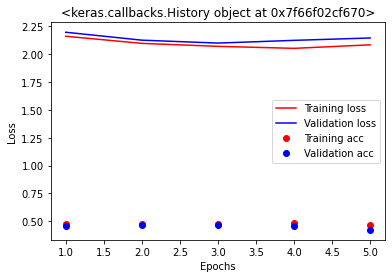

In [66]:
history(model_history)

In [77]:
lstm_results = model.evaluate(X_test, y_test)
print(lstm_results)

71/71 [==============================] - 1s 10ms/step - loss: 2.0752 - accuracy: 0.4800
[2.075212240219116, 0.47996437549591064]


In [79]:
lstm_results[1]

0.47996437549591064

In [80]:
def lstm_metric(X_test, y_test):
    
    acc = model.evaluate(X_test, y_test)[1]
    
    # 클래스 예측
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    #데이터프레임 변환
    result = pd.DataFrame({'model_name':['LSTM'],
                           'accuracy':[acc],
                           'precision':[precision],
                           'recall':[recall],
                           'f1-score':[f1]})
    
    return result
    

In [81]:
lstm_result = lstm_metric(X_test, y_test)
lstm_result

71/71 [==============================] - 1s 11ms/step - loss: 2.0752 - accuracy: 0.4800


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy,precision,recall,f1-score
0,LSTM,0.479964,0.359893,0.479964,0.388529


# 머신러닝과 딥러닝 비교

In [84]:
final_result = pd.concat([all_result_, lstm_result]).reset_index(drop=True)
final_result

,model_name,accuracy,precision,recall,f1-score
0,Naive Bayes,0.599733,0.498564,0.599733,0.504567
1,Complement NB,0.764915,0.745940,0.764915,0.734653
2,Logistic Regression,0.816563,0.818232,0.816563,0.811443
3,SVM,0.791184,0.794166,0.791184,0.787119
4,DecisionTree,0.620214,0.618924,0.620214,0.575475
5,RandomForest,0.652271,0.628474,0.652271,0.621143
6,GradientBoost,0.769368,0.770238,0.769368,0.765951
7,ensemble,0.810329,0.813163,0.810329,0.799433
8,LSTM,0.479964,0.359893,0.479964,0.388529


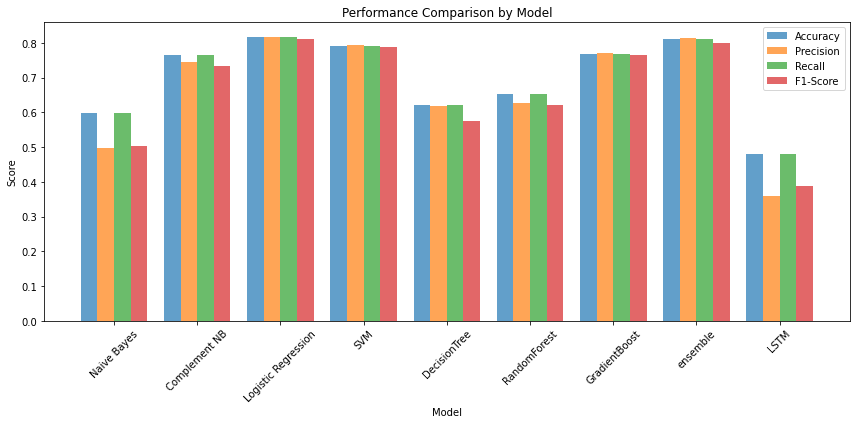

In [87]:
# 모델별 성능 지표 추출
model_names = final_result['model_name']
accuracy_scores = final_result['accuracy']
precision_scores = final_result['precision']
recall_scores = final_result['recall']
f1_scores = final_result['f1-score']

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))

# 막대 너비
bar_width = 0.2

# x 좌표 계산
x = np.arange(len(model_names))

# Accuracy 막대 그리기
plt.bar(x, accuracy_scores, width=bar_width, label='Accuracy', alpha=0.7)

# Precision 막대 그리기
plt.bar(x + bar_width, precision_scores, width=bar_width, label='Precision', alpha=0.7)

# Recall 막대 그리기
plt.bar(x + 2 * bar_width, recall_scores, width=bar_width, label='Recall', alpha=0.7)

# F1-Score 막대 그리기
plt.bar(x + 3 * bar_width, f1_scores, width=bar_width, label='F1-Score', alpha=0.7)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Comparison by Model')
plt.xticks(x + 1.5 * bar_width, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

- 전체적으로 LSTM의 성능이 떨어지는 것을 확인할 수 있습니다.
- Logistic Regression과 Ensemble 모델은 f1-score 기준 약 0.8의 성능을 보였지만, LSTM은 약 0.38의 성능을 보였습니다.
- 그 이유는 다양한 요인에 의해 결정될 수 있습니다.
1. 데이터 양과 특성
    - 로이터 뉴스 데이터는 상대적으로 작은 크기의 데이터셋이며, 텍스트 데이터로 구성되어 있습니다. 머신러닝 알고리즘은 작은 데이터셋에서도 상대적으로 좋은 성능을 발휘할 수 있습니다. 머신러닝 알고리즘은 데이터에 대한 수작업으로 설계된 특징을 사용하여 패턴을 학습하는 데 효과적일 수 있습니다.
2. 모델 복잡도
    - 딥러닝 모델은 여러 개의 층으로 구성되고 많은 파라미터를 가질 수 있습니다. 반면에 머신러닝 알고리즘은 일반적으로 더 간단한 모델 구조를 가지며, 파라미터 수가 적을 수 있습니다. 작은 데이터셋에서는 더 간단한 모델이 과적합을 방지하고 일반화 성능을 높일 수 있기 때문에 머신러닝 알고리즘이 성능이 더 좋을 수 있습니다.
3. 특정 데이터셋의 특성
    - 로이터 뉴스 데이터셋의 특성에 따라 머신러닝 알고리즘이 더 잘 맞을 수 있습니다. 예를 들어, 텍스트 데이터에는 단어의 빈도, TF-IDF 등의 특성을 활용할 수 있는 머신러닝 알고리즘들이 잘 동작할 수 있습니다.

- 더욱 다양한 이유가 존재할 수 있지만, 해당 데이터셋에는 딥러닝보다는 머신러닝 모델이 적합할 수 있다고 생각합니다.

# 전체 회고
- 당연히 딥러닝 모델이 우수할거라고 생각했지만, 그렇지 않았습니다.
- 데이터의 특성이 모델에 영향을 많이 끼친다는 것을 깨달은 프로젝트였습니다.
- 코드를 함수화하기 위해 많은 노력을 했던것 같습니다.
- 또한 결과를 알아보기 쉽게 시각화하는것에 대해 많은 고민을 한 것 같습니다.

# 참고 자료
- 이전 노드
- https://beneagain.tistory.com/117
- https://wikidocs.net/22933
- https://aimb.tistory.com/152
- https://scikit-learn.org/stable/search.html?q=fit